In [1]:
from collections import defaultdict
import heapq
from operator import itemgetter
import random
import sys
from composables.composable_base import Composable
from exceptions import DuplicateNodeNameException, NodeTypeNotFoundException
from joblib import Parallel, delayed
import numpy as np

import multiprocessing
from multiprocessing import Manager

class Edge:
    def __init__(self):
        self.lnode = None
        self.rnode = None

    def remove(self):
        self.lnode.edges.remove(self)
        self.rnode.edges.remove(self)
        self.lnode = None
        self.rnode = None

# Class for a node in the graph
class Node:
    def __init__(self, id, type):
        self.edges = []
        self.id = id
        self.type = type

    # Add an edge connected to another node
    def add_edge(self, node):
        edge = Edge()
        edge.lnode = self
        edge.rnode = node
        self.edges.append(edge)
        return edge

    def __le__(self, other):
        return self

    def __lt__(self, other):
        return self

    # Remove an edge from the node
    def remove_edge(self, edge):
        self.edges.remove(edge)

    # Decide if another node is a neighbor
    def is_neighbor(self, node):
        for edge in self.edges:
            if edge.lnode == node or edge.rnode == node:
                return True
        return False

class Graph:
    def __init__(self, name: str) -> None:
        self.composables: list[Composable]  = []
        self.graph_name = name

        self.nodes: list[Node] = []
        self.node_names: list[str] = []
        self.edges: list[Edge] = []

        self.adjacency_matrix = None

    def add_composable(self, composable: Composable):
        self.composables.append(composable)

    def add_node(self, n: str, t: str) -> Node:
        if n in self.node_names:
            raise DuplicateNodeNameException()

        nd = Node(n, t)
        self.nodes.append(nd)
        self.node_names.append(n)

        for c in self.composables:
            c.add_node(n)

        return nd

    def add_edge(self, n1: str, n2: str):
        n_1 = self.nodes[self.node_names.index(n1)]
        n_2 = self.nodes[self.node_names.index(n2)]

        edge = n_1.add_edge(n_2)
        n_2.add_edge(n_1)

        self.edges.append(edge)

        for c in self.composables:
            c.add_edge(n1, n2)
    
    def get_node_by_id(self, id: str) -> Node:
        for n in self.nodes:
            if n.id == id:
                return n
        
        return None
            
    def remove_edge(self, n: Node, t: Node):
        edge_to_remove = None
        for e in n.edges:
            if e.rnode.id == t.id and e.lnode.id == n.id:
                edge_to_remove = e
                break
                
        if edge_to_remove:
            n.remove_edge(edge_to_remove)
        
        for c in self.composables:
            c.remove_edge(n.id, t.id)

    def create_nodes_from_array(self, node_defn_array: list) -> None:
        for n in node_defn_array:
            if n[1].get('type') == None:
                raise NodeTypeNotFoundException()
            self.add_node(n[0], n[1].get('type'))

    def generate_adjancency_matrix(self):
        if self.adjacency_matrix != None:
            return self.adjacency_matrix

        adj = [[float('inf') for i in range(len(self.nodes))] for j in range(len(self.nodes))]

        for i in range(len(self.nodes)):
            for j in range(len(self.nodes)):
                if self.nodes[i].is_neighbor(self.nodes[j]):
                    adj[i][j] = 1

        self.adjacency_matrix = adj

        return adj

    def define_topology(self):
        pass

    def compute_dijikstra_using_spt(self, src: Node, dst: Node):
        src_idx = self.node_names.index(src.id)
        dst_idx = self.node_names.index(dst.id)

        adj_mat = self.generate_adjancency_matrix()

        dist = [sys.maxsize] * len(self.nodes)
        dist[src_idx] = 0
        sptSet = [False] * len(self.nodes)

        for _ in range(len(self.nodes)):

            min_idx = None
            min_val = sys.maxsize
            for u in range(len(self.nodes)):
                if dist[u] < min_val and sptSet[u] == False:
                    min_val = dist[u]
                    min_idx = u

            if min_idx != None:
                sptSet[min_idx] = True

            for y in range(len(self.nodes)):
                if adj_mat[min_idx][y] > 0 and sptSet[y] == False and dist[min_idx] != sys.maxsize and dist[y] > dist[min_idx] + adj_mat[min_idx][y]:
                        dist[y] = dist[min_idx] + adj_mat[min_idx][y]

        return dist[dst_idx]

    def compute_dijkstra_using_heap(self, src: Node, dst: Node = None):
        visited = set()
        priority_queue = []

        pathMap = {}

        distance = defaultdict(lambda: sys.maxsize)
        distance[src.id] = 0

        heapq.heappush(priority_queue, (0, src))

        while priority_queue:

            _, node = heapq.heappop(priority_queue)
            visited.add(node)

            for edge in node.edges:
                if edge.rnode in visited:
                    continue
        
                new_distance = distance[node.id] + 1

                if distance[edge.rnode.id] > new_distance:
                    distance[edge.rnode.id] = new_distance

                    pathMap[edge.rnode] = node
                    
                    heapq.heappush(priority_queue, (new_distance, edge.rnode))

        return distance, pathMap

    def path(self, previous, node_start, node_end):
        route = []

        node_curr = node_end    
        while True:
            route.append(node_curr)
            if previous.get(node_curr) == None:
                break
                
            if previous.get(node_curr).id == node_start.id:
                route.append(node_start)
                break

            node_curr = previous[node_curr]

        route.reverse()
        return route

    def compute_dijikstra_for_all_hosts(self):
        hosts = self.get_all_hosts()

        computed_paths = Manager().dict()

        def processInput(idx):
            t_res = []
            remaining_hosts = hosts[0:idx] + hosts[idx+1:len(hosts)]
            print(f"host {idx+1} of {len(hosts)}")
            for rem in remaining_hosts:
                path_name = None
                if computed_paths.get(f"{hosts[idx].id}:{rem.id}") != None:
                    path_name = f"{hosts[idx].id}:{rem.id}"
                elif computed_paths.get(f"{rem.id}:{hosts[idx].id}") != None:
                    path_name = f"{rem.id}:{hosts[idx].id}"

                if path_name != None:
                    t_res.append(computed_paths[path_name])

                else:
                    path_name = f"{hosts[idx].id}:{rem.id}"
                    computed_paths[path_name] = self.compute_dijkstra_using_heap(hosts[idx], rem)[0][rem.id]
                    t_res.append(computed_paths[path_name])

            return t_res

        num_cores = multiprocessing.cpu_count()
        print(f"parallelising using {num_cores} cores")

        results = Parallel(n_jobs=num_cores, prefer="threads")(delayed(processInput)(i) for i in range(0, len(hosts)))

        return [i for sublist in results for i in sublist]


    def get_all_hosts(self):
        host_idxs = list(filter(lambda x: x[1].startswith('h'), enumerate(self.node_names)))

        hosts = []

        for id in host_idxs:
            hosts.append(self.nodes[id[0]])

        return hosts

    def compute_yen_ksp(self, node_start: Node, node_end: Node, max_k=2):
        distances, previous = self.compute_dijkstra_using_heap(node_start)

        A = [{'cost': distances[node_end.id], 
            'path': self.path(previous, node_start, node_end)}]
        B = []

        if not A[0]['path']: return A

        for k in range(1, max_k):
            current_path = A[-1]['path']
            for i in range(0, len(current_path) - 1):
                node_spur = A[-1]['path'][i]
                path_root = A[-1]['path'][:i+1]

                edges_removed = []
                for path_k in A:
                    curr_path = path_k['path']
                    if len(curr_path) > i and path_root == curr_path[:i+1]:
                        self.remove_edge(curr_path[i], curr_path[i+1])

                        edges_removed.append([curr_path[i], curr_path[i+1]])
                    

                path_spur, prev_path_spur = self.compute_dijkstra_using_heap(node_spur, node_end)
                
                path_total = path_root[:-1] + self.path(prev_path_spur, node_spur, node_end)
                dist_total = distances[node_spur.id] + path_spur[node_end.id]
                potential_k = {'cost': dist_total, 'path': path_total}

                if not (potential_k in B):
                    B.append(potential_k)

                for edge in edges_removed:
                    self.add_edge(edge[0].id, edge[1].id)

            if len(B):
                B = sorted(B, key=itemgetter('cost'))
                A.append(B[0])
                B.pop(0)
            else:
                break

        return A

    def compute_yen_for_server_permutation_pairs(self):
        original_hosts = self.get_all_hosts()

        shuffled_hosts = self.get_all_hosts()
        random.shuffle(shuffled_hosts)

        permuted_pairs = zip(original_hosts, shuffled_hosts)

        computed_paths = {}
        eight_path = {}
        sixty_four_ecmp = {}

        for h in permuted_pairs:
            path_name = None
            if computed_paths.get(f"{h[0].id}:{h[1].id}") != None:
                path_name = f"{h[0].id}:{h[1].id}"
            elif computed_paths.get(f"{h[1].id}:{h[0].id}") != None:
                path_name = f"{h[1].id}:{h[0].id}"

            if computed_paths.get(path_name) == None:
                path_name = f"{h[0].id}:{h[1].id}"
                print(f"Computing for {path_name}")
                computed_paths[path_name] = self.compute_yen_ksp(h[0], h[1], 64)
                
            eight_path[path_name] = self.get_ecmp_paths(h, computed_paths, 8)
            sixty_four_ecmp[path_name] = self.get_ecmp_paths(h, computed_paths, 64)

        return computed_paths, eight_path, sixty_four_ecmp


    def get_ecmp_paths(self, host_pair: tuple[Node, Node], computed_paths: dict[str, list], required_path_count: int):
        path_name = f"{host_pair[0].id}:{host_pair[1].id}"

        paths_equal_to_shortest_path = []


        try:
            all_paths = computed_paths[path_name]

            shortest_path = all_paths[0]

            for p in all_paths[1:]:
                if len(p['path']) == len(shortest_path['path']):
                    paths_equal_to_shortest_path.append(p)

                if len(paths_equal_to_shortest_path) == required_path_count:
                    break

            return paths_equal_to_shortest_path

        except KeyError:
            print("Key not found for hosts: {host_pair[0].id} and {host_pair[1].id}")
            return []

    def calculate_centrality(self, computed_paths: dict[str, list]):
        centrality_of_switches = {}

        for _, cp in computed_paths.items():
            for path in cp:
                for node in path['path']:
                    if node.id.startswith('s'):
                        centrality_of_switches[node.id] = (centrality_of_switches.get(node.id) or 0) + 1
        
        return centrality_of_switches

class BCubeTopo(Graph):
    def __init__(self, n, k) -> None:
        super().__init__("b-cube")

        self.k = k # level in bcube starts from 0 ( total number of levels )
        self.n = n # denoted as n in the paper ( number of servers in each cube )

        self.num_hosts = n ** (k + 1)

        self.hosts = [('h_' + str(i), {'type': 'host'})
             for i in range (1, self.num_hosts + 1)]
        
        self.switches = []

    def generate_bcube_structure(self) -> None:
        self.create_nodes_from_array(self.hosts)

        for curr_level in range(0, self.k + 1):
            for j in range(0, self.n ** self.k):
                switch = self.add_node(f's_{curr_level}_{j}', 'switch')

                self.switches.append(switch)

                hosts_to_connect = range(j, j + self.n ** (curr_level + 1), self.n ** curr_level)

                for h in hosts_to_connect:
                    self.add_edge(switch.id, self.hosts[h][0])


class DCellTopo(Graph):
    def __init__(self, n, l) -> None:
        super().__init__("d-cell")

        self.l = l # level in dcell starts from 0 ( total number of levels )
        self.n = n # denoted as n in the paper ( number of servers in each cell )

        self.hosts = []
        
        self.create_nodes_from_array(self.hosts)
        
        self.switches = []

        self.switch_count = 0
        self.host_count = 0

        self.virtual_edge_count = 0

    def generate_dcell_structure(self, level: int) -> None:
        if level == 0:
            switch = self.add_node(f's_{level}_{self.switch_count}', 'switch')
            self.switch_count += 1

            temp_host_arr = []

            self.switches.append(switch)

            for i in range (self.n):
                h = f'h_{self.host_count}'
                self.host_count += 1

                self.add_node(h, 'host')
                self.host_count += 1

                temp_host_arr.append({
                    'host': h,
                    'connected': False
                })

                self.hosts.append(h)

                self.add_edge(switch.id, h)
            
            return temp_host_arr

        else:
            hosts_arr = []

            num_server_in_prev_level = self.get_num_server(level - 1)
            num_of_cells_in_curr_level = num_server_in_prev_level + 1

            for c in range(num_of_cells_in_curr_level):
                hosts_arr.append({c: self.generate_dcell_structure(level-1)})

            for i in range(num_of_cells_in_curr_level - 1):
                for j in range(i+1, num_of_cells_in_curr_level):
                    self.connect_virtual_hosts(hosts_arr[i], hosts_arr[j])

            out = []
            for sublist in hosts_arr:
                for k, v in sublist.items():
                    out.extend(v)
            
            for i in out:
                i['connected'] = False

            return out


    def connect_virtual_hosts(self, v1: dict[int, list], v2: dict[int, list]):
        n1 = list(filter(lambda x: x['connected'] == False, list(v1.values())[0]))[0]
        n2 = list(filter(lambda x: x['connected'] == False, list(v2.values())[0]))[0]

        n1['connected'] = True
        n2['connected'] = True

        self.virtual_edge_count += 1

        self.add_edge(n1['host'], n2['host'])
                    

    def get_num_server(self, level: int):
        if level == 0:
            return self.n
        
        serv_in_prev = self.get_num_server(level - 1)

        return serv_in_prev * (serv_in_prev + 1)

        

            

In [4]:
from composables.networkx_composable import NetworkxVisualizationComposer

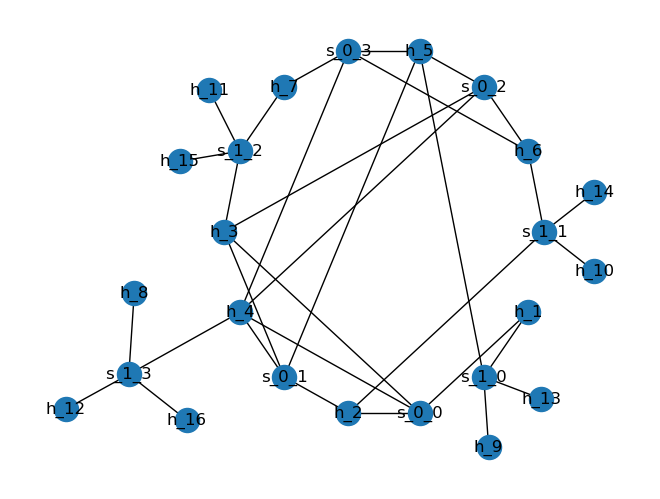

In [9]:
dc = BCubeTopo(4, 1)
n = NetworkxVisualizationComposer()
dc.add_composable(n)

dc.generate_bcube_structure()
n.draw("circo")

In [24]:
dc.virtual_edge_count

420

In [25]:
dc.get_num_server(2)

420

In [9]:
n = len(dc.nodes)

In [10]:
n

25

In [13]:
5 * (5 - 1) / 2

10.0

In [12]:
ne

30

In [7]:
dc_4_1 = DCellTopo(4, 1)
n_dc_4_1 = NetworkxVisualizationComposer()
dc_4_1.add_composable(n_dc_4_1)

dc_4_1.generate_dcell_structure(1)

# n_dc_4_1.draw("circo")

[{'host': 'h_0', 'connected': False},
 {'host': 'h_2', 'connected': False},
 {'host': 'h_4', 'connected': False},
 {'host': 'h_6', 'connected': False},
 {'host': 'h_8', 'connected': False},
 {'host': 'h_10', 'connected': False},
 {'host': 'h_12', 'connected': False},
 {'host': 'h_14', 'connected': False},
 {'host': 'h_16', 'connected': False},
 {'host': 'h_18', 'connected': False},
 {'host': 'h_20', 'connected': False},
 {'host': 'h_22', 'connected': False},
 {'host': 'h_24', 'connected': False},
 {'host': 'h_26', 'connected': False},
 {'host': 'h_28', 'connected': False},
 {'host': 'h_30', 'connected': False},
 {'host': 'h_32', 'connected': False},
 {'host': 'h_34', 'connected': False},
 {'host': 'h_36', 'connected': False},
 {'host': 'h_38', 'connected': False}]

In [9]:
computed_paths = dc_4_1.compute_yen_for_server_permutation_pairs()

Computing for h_0:h_38
Computing for h_2:h_0
Computing for h_4:h_36
Computing for h_6:h_2
Computing for h_8:h_16
Computing for h_10:h_32
Computing for h_12:h_28
Computing for h_14:h_30
Computing for h_16:h_4
Computing for h_18:h_34
Computing for h_20:h_20
Computing for h_22:h_24
Key not found for hosts: {host_pair[0].id} and {host_pair[1].id}
Key not found for hosts: {host_pair[0].id} and {host_pair[1].id}
Computing for h_26:h_14
Key not found for hosts: {host_pair[0].id} and {host_pair[1].id}
Key not found for hosts: {host_pair[0].id} and {host_pair[1].id}
Computing for h_30:h_10
Computing for h_32:h_18
Computing for h_34:h_6
Computing for h_36:h_8
Computing for h_38:h_26


In [14]:
computed_paths

({'h_0:h_38': [{'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]},
   {'cost': 5,
    'path': [<__main__.Node at 0x116c0bb10>,
     <__main__.Node at 0x116c1af50>]}

In [13]:

dc_4_1.calculate_centrality(computed_paths[1])

{'s_0_0': 48, 's_0_4': 56, 's_0_1': 40, 's_0_3': 16, 's_0_2': 8}